## Import Packages and Datasets

In [1]:
# Import packages
import scanpy as sc
from seaborn.matrix import dendrogram



In [26]:
# Import Datasets

# Normal CellHint scRNA Dataset (Human Kidney)
## ~ 33k Genes
normal = sc.read_h5ad('/Volumes/CHAMPANERI/Databases/Human_Nor_Kidney_CellHint_scRNA.h5ad')

# Healthy and Injured Cell States and Niches in the Human Kidney ––– scRNA
## ~ 31k Genes
# scRNA_ckd = sc.read_h5ad('/Volumes/CHAMPANERI/Databases/Human_Nor-CKD-AKF_scRNA.h5ad')

# Healthy and Injured Cell States and Niches in the Human Kidney ––– scRNA
## ~ 36k Genes
# snRNA_ckd = sc.read_h5ad('/Volumes/CHAMPANERI/Databases/Human_Nor-CKD-AKF_snRNA.h5ad')

## Gene Dictionaries

In [27]:
# Define Initial Search Gene Dictionary
all_genes = {
    'C1D': 'ENSG00000197223',
    'C1QA': 'ENSG00000173372',
    'C1QB': 'ENSG00000173369',
    'C1QC': 'ENSG00000159189',
    'C1QBP': 'ENSG00000108561',
    'C1R': 'ENSG00000159403',
    'C1RL': 'XXX',
    'C1S': 'ENSG00000182326',
    # 'C2': 'ENSG00000166278',
    'C2_ENSG00000166278': 'ENSG00000166278',
    # 'C3': 'ENSG00000125730',
    'C3_ENSG00000125730': 'ENSG00000125730',
    'C3AR1': 'ENSG00000171860',
    'C4A': 'ENSG00000244731',
    'C4B': 'ENSG00000224389',
    'C4BPA': 'XXX',
    'C4BPB': 'XXX',
    'C5': 'ENSG00000106804',
    'C5AR1': 'ENSG00000197405',
    'C5AR2': 'ENSG00000134830',
    # 'C6': 'ENSG00000039537',
    'C6_ENSG00000039537': 'ENSG00000039537',
    # 'C7': 'ENSG00000112936',
    'C7_ENSG00000112936': 'ENSG00000112936',
    'C8A': 'XXX',
    'C8B': 'XXX',
    'C8G': 'XXX',
    # 'C9': 'ENSG00000113600',
    'C9_ENSG00000113600': 'ENSG00000113600',
    'CALR': 'XXX',
    'CD46': 'ENSG00000117335',
    'CD55': 'ENSG00000196352',
    'CD59': 'ENSG00000085063',
    'CD93': 'XXX',
    'CFB': 'ENSG00000243649',
    'CFD': 'ENSG00000197766',
    'CFH': 'ENSG00000000971',
    'CFHR1': 'XXX',
    'CFHR2': 'XXX',
    'CFHR3': 'XXX',
    'CFHR4': 'XXX',
    'CFHR5': 'XXX',
    'CFI': 'ENSG00000205403',
    'CLU': 'XXX',
    'COLEC10': 'XXX',
    'COLEC11': 'XXX',
    'CPB2': 'XXX',
    'CPN1': 'XXX',
    'CPN2': 'XXX',
    'CSMD1': 'XXX',
    'CFP': 'ENSG00000126759',
    'CR1': 'ENSG00000203710',
    'CR2': 'ENSG00000117322',
    'FCN1': 'ENSG00000085265',
    'FCN2': 'ENSG00000160339',
    'FCN3': 'ENSG00000142748',
    'ITGAM': 'XXX',
    'ITGAMX': 'XXX',
    'ITGAX': 'XXX',
    'ITGB2': 'XXX',
    'MASP1': 'XXX',
    'MASP2': 'XXX',
    'MASP3': 'XXX',
    'MBL2': 'XXX',
    'SERPING1': 'XXX',
    'SUSD4': 'XXX',
    'VSIG4': 'XXX',
    'VCP': 'ENSG00000165280'
}

### Class to find genes by symbol only and then map gene IDs

> Prints "gene_dict" which contains all the genes and their IDs in the dataset
> - To add more genes, add them to the all_genes dictionary using "gene_symbol": "ensembl_id" format and run the code below
> - Priority is given to the gene symbol so input that first and then let the program find the gene ID

In [31]:
class GeneMapper:
    """
    A class for finding, mapping and merging gene symbols across multiple datasets.
    """

    @staticmethod
    def find_genes_in_dataset(adata, gene_dict):
        """
        Find genes in an AnnData object based on symbols in feature_name column.

        Parameters:
        -----------
        adata : AnnData
            The AnnData object to search
        gene_dict : dict
            Dictionary with gene symbols as keys

        Returns:
        --------
        tuple
            (found_symbols, not_found_symbols, symbol_to_id_dict)
        """
        found = []
        not_found = []
        symbol_to_id = {}

        # Check if feature_name column exists
        if 'feature_name' not in adata.var.columns:
            print("Warning: feature_name column not found in dataset.")
            return [], list(gene_dict.keys()), {}

        # Create lookup for faster searching
        feature_to_index = {name: idx for idx, name in enumerate(adata.var['feature_name'])}

        # Process each gene symbol
        for symbol in gene_dict.keys():
            if symbol in feature_to_index:
                found.append(symbol)
                # Map to gene ID immediately
                index = feature_to_index[symbol]
                gene_id = adata.var_names[index]
                symbol_to_id[symbol] = gene_id
            else:
                not_found.append(symbol)

        return found, not_found, symbol_to_id

    @classmethod
    def create_merged_dictionary(cls, all_genes, datasets_dict, verbose=True):
        """
        Create a merged dictionary of gene symbols from original dict and all datasets.

        Parameters:
        -----------
        all_genes : dict
            Original dictionary with manually defined gene_symbol:ensembl_id pairs
        datasets_dict : dict
            Dictionary of {dataset_name: dataset} pairs
        verbose : bool
            Whether to print progress information

        Returns:
        --------
        dict
            Merged dictionary with gene symbols as keys and their IDs as values
        """
        # Start with a copy of the original dictionary
        merged_dict = all_genes.copy()
        conflicts = {}

        # Track statistics for reporting
        stats = {name: {"found": 0, "mapped": 0} for name in datasets_dict}

        # Process each dataset
        for name, dataset in datasets_dict.items():
            found, not_found, symbol_to_id = cls.find_genes_in_dataset(dataset, all_genes)
            stats[name]["found"] = len(found)
            stats[name]["mapped"] = len(symbol_to_id)

            # Add to merged dictionary, tracking any conflicts
            for symbol, gene_id in symbol_to_id.items():
                if symbol in merged_dict and merged_dict[symbol] != "XXX" and merged_dict[symbol] != gene_id:
                    if symbol not in conflicts:
                        conflicts[symbol] = {merged_dict[symbol]: "original"}
                    conflicts[symbol][gene_id] = name
                else:
                    merged_dict[symbol] = gene_id

        # Report findings if verbose
        if verbose:
            # Print dataset statistics
            for name, dataset_stats in stats.items():
                print(f"\n{name} dataset:")
                print(f"  Found: {dataset_stats['found']}/{len(all_genes)} genes "
                      f"({dataset_stats['found']/len(all_genes):.1%})")
                print(f"  Mapped: {dataset_stats['mapped']}/{dataset_stats['found']} genes")

            # Report conflicts
            if conflicts:
                print(f"\nFound {len(conflicts)} genes with different IDs across datasets:")
                for symbol, sources in conflicts.items():
                    print(f"  {symbol}: {sources}")

            # Print overall statistics
            print(f"\nMerged dictionary contains {len(merged_dict)} genes")
            print(f"Original dictionary contained {len(all_genes)} genes")
            print(f"Added {len(merged_dict) - len(all_genes)} new genes")

        return merged_dict

# Example usage
if __name__ == "__main__":
    # Create a dictionary of datasets
    datasets = {
        "Normal": normal,
        "scRNA_ckd": scRNA_ckd,
        "snRNA_ckd": snRNA_ckd
    }

    # Create the merged dictionary
    merged_genes = GeneMapper.create_merged_dictionary(all_genes, datasets)

    # Print some example entries
    print("\nSample entries:")
    gene_dict = list(merged_genes.items())[:70]
    for symbol, gene_id in gene_dict:
        print(f"  {symbol}: {gene_id}")


Normal dataset:
  Found: 51/63 genes (81.0%)
  Mapped: 51/51 genes

scRNA_ckd dataset:
  Found: 59/63 genes (93.7%)
  Mapped: 59/59 genes

snRNA_ckd dataset:
  Found: 61/63 genes (96.8%)
  Mapped: 61/61 genes

Merged dictionary contains 63 genes
Original dictionary contained 63 genes
Added 0 new genes

Sample entries:
  C1D: ENSG00000197223
  C1QA: ENSG00000173372
  C1QB: ENSG00000173369
  C1QC: ENSG00000159189
  C1QBP: ENSG00000108561
  C1R: ENSG00000159403
  C1RL: ENSG00000139178
  C1S: ENSG00000182326
  C2_ENSG00000166278: ENSG00000166278
  C3_ENSG00000125730: ENSG00000125730
  C3AR1: ENSG00000171860
  C4A: ENSG00000244731
  C4B: ENSG00000224389
  C4BPA: ENSG00000123838
  C4BPB: ENSG00000123843
  C5: ENSG00000106804
  C5AR1: ENSG00000197405
  C5AR2: ENSG00000134830
  C6_ENSG00000039537: ENSG00000039537
  C7_ENSG00000112936: ENSG00000112936
  C8A: ENSG00000157131
  C8B: ENSG00000021852
  C8G: ENSG00000176919
  C9_ENSG00000113600: ENSG00000113600
  CALR: ENSG00000179218
  CD46: ENSG0

### Generating Functional Gene Dictionaries
_Separate dictionaries for each type of gene as follows:_

1. Classical Pathway Components
    - Enzymatic Activation (Convertase Formation)
    - Recognition (C1 Complex)
2. Lectin Pathway Components
    - Recognition (Lectins and Collectins)
    - Enzymatic Activation (MASP Proteases)
3. Alternative Pathway Components
4. Terminal Pathway and Membrane Attack Complex (MAC) Components
5. Complement Receptors
    - Soluble Regulators
    - Membrane-Bound Receptors
6. Complement Regulatory Proteins
7. Other Complement-Related Proteins

---

> Massive Library of Complement Gene Dictionaries Essentially
>
> Accessing: complement_genes, pattern_recognition_genes, complement_proteases, complement_component_genes, complement_receptor_genes, complement_regulator_genes
>
> e.g. complement_genes["classical_pathway"]["enzymatic_activation"]
>
> e.g. pattern_recognition_genes["classical_pathway_prms"]



In [44]:
complement_genes = {
    # 1. Classical Pathway Components
    # These genes encode proteins involved in the classical pathway, which is triggered by antibody-antigen complexes.
    "classical_pathway": {
        "enzymatic_activation": {  # Proteins involved in forming the C3 and C5 convertases
            'C1R': 'ENSG00000159403',  # C1R serine protease
            'C1RL': 'ENSG00000139178',  # C1R-like protein
            'C1S': 'ENSG00000182326',  # C1S serine protease
            'C2_ENSG00000166278': 'ENSG00000166278'  # C2, key for classical and lectin pathway convertases
        },
        "recognition": {  # Proteins that recognize immune complexes and initiate activation
            'C1QA': 'ENSG00000173372',  # C1q subunit A
            'C1QB': 'ENSG00000173369',  # C1q subunit B
            'C1QC': 'ENSG00000159189',  # C1q subunit C
            'C1QBP': 'ENSG00000108561'  # C1q binding protein, modulator of the pathway
        }
    },

    # 2. Lectin Pathway Components
    # These genes encode proteins responsible for recognizing carbohydrate patterns on pathogens.
    "lectin_pathway": {
        "recognition": {  # Pattern recognition molecules (PRMs) binding to carbohydrate motifs
            'MBL2': 'ENSG00000165471',  # Mannose-binding lectin
            'FCN1': 'ENSG00000085265',  # Ficolin-1
            'FCN2': 'ENSG00000160339',  # Ficolin-2
            'FCN3': 'ENSG00000142748',  # Ficolin-3
            'COLEC10': 'ENSG00000184374',  # Collectin-10
            'COLEC11': 'ENSG00000118004'  # Collectin-11
        },
        "enzymatic_activation": {  # MASP proteases that trigger the complement cascade
            'MASP1': 'ENSG00000127241',  # Mannose-associated serine protease 1
            'MASP2': 'ENSG00000009724',  # Mannose-associated serine protease 2
            'MASP3': 'XXX'  # Mannose-associated serine protease 3 (Unresolved ENSG ID)
        }
    },

    # 3. Alternative Pathway Components
    # This pathway is constantly activated at a low level and can amplify complement response.
    "alternative_pathway": {
        'C3_ENSG00000125730': 'ENSG00000125730',  # C3, central to all pathways
        'CFB': 'ENSG00000243649',  # Complement factor B, alternative pathway convertase
        'CFD': 'ENSG00000197766',  # Complement factor D, initiator of alternative pathway
        'CFP': 'ENSG00000126759'  # Properdin, stabilizer of alternative pathway convertase
    },

    # 4. Terminal Pathway and Membrane Attack Complex (MAC) Components
    # These genes encode proteins forming the Membrane Attack Complex, responsible for cell lysis.
    "terminal_pathway_mac": {
        'C5': 'ENSG00000106804',  # C5, precursor to MAC formation
        'C6_ENSG00000039537': 'ENSG00000039537',  # C6, MAC component
        'C7_ENSG00000112936': 'ENSG00000112936',  # C7, MAC component
        'C8A': 'ENSG00000157131',  # C8 alpha subunit, MAC component
        'C8B': 'ENSG00000021852',  # C8 beta subunit, MAC component
        'C8G': 'ENSG00000176919',  # C8 gamma subunit, MAC component
        'C9_ENSG00000113600': 'ENSG00000113600'  # C9, final MAC component
    },

    # 5. Complement Receptors
    # These genes encode receptors that recognize complement components and mediate immune signaling.
    "complement_receptors": {
        "soluble_regulators": {  # Receptors that bind soluble complement components
            'C3AR1': 'ENSG00000171860',  # C3a receptor
            'C5AR1': 'ENSG00000197405',  # C5a receptor 1
            'C5AR2': 'ENSG00000134830'  # C5a receptor 2
        },
        "membrane_bound_receptors": {  # Cell-surface receptors mediating immune functions
            'CR1': 'ENSG00000203710',  # Complement receptor 1
            'CR2': 'ENSG00000117322',  # Complement receptor 2
            'ITGAM': 'ENSG00000169896',  # Integrin alpha-M (Mac-1, CD11b)
            'ITGAX': 'ENSG00000140678',  # Integrin alpha-X (CD11c)
            'ITGB2': 'ENSG00000160255'  # Integrin beta-2
        }
    },

    # 6. Complement Regulatory Proteins
    # These genes encode proteins that regulate complement activity and prevent overactivation.
    "complement_regulatory_proteins": {
        'CFH': 'ENSG00000000971',  # Complement factor H, regulator of alternative pathway
        'CFHR1': 'ENSG00000244414',  # Complement factor H-related 1
        'CFHR2': 'ENSG00000080910',  # Complement factor H-related 2
        'CFHR3': 'ENSG00000116785',  # Complement factor H-related 3
        'CFHR4': 'ENSG00000134365',  # Complement factor H-related 4
        'CFHR5': 'ENSG00000134389',  # Complement factor H-related 5
        'CFI': 'ENSG00000205403',  # Complement factor I, degrades C3b/C4b
        'SERPING1': 'ENSG00000149131',  # C1 inhibitor, regulates classical/lectin pathways
        'CLU': 'ENSG00000120885',  # Clusterin, regulates MAC formation
        'C4BPA': 'ENSG00000123838',  # C4b-binding protein alpha
        'C4BPB': 'ENSG00000123843',  # C4b-binding protein beta
        'CD46': 'ENSG00000117335',  # Membrane cofactor protein (MCP)
        'CD55': 'ENSG00000196352',  # Decay accelerating factor (DAF)
        'CD59': 'ENSG00000085063',  # CD59, MAC inhibitory protein
        'VSIG4': 'ENSG00000155659'  # Negative regulator of complement activation
    },

    # 7. Other Complement-Related Proteins
    # These genes encode proteins that are associated with the complement system but are not directly part of activation or regulation.
    "other_complement_related_proteins": {
        'CD93': 'ENSG00000125810',  # Cell surface glycoprotein involved in phagocytosis
        'CSMD1': 'ENSG00000183117',  # Regulator of complement activation
        'SUSD4': 'ENSG00000143502',  # Complement-related signaling molecule
        'VCP': 'ENSG00000165280',  # p97/VCP, involved in protein homeostasis
        'CPB2': 'ENSG00000080618',  # Carboxypeptidase B2, inactivates C3a/C5a
        'CPN1': 'ENSG00000120054',  # Carboxypeptidase N subunit 1, regulates anaphylatoxins
        'CPN2': 'ENSG00000178772'  # Carboxypeptidase N subunit 2, regulator of C3a/C5a
    }
}

pattern_recognition_genes = {
    # 1. Classical Pathway PRMs
    # These recognize immune complexes and apoptotic cells to initiate the classical pathway.
    "classical_pathway_prms": {
        'C1QA': 'ENSG00000173372',  # C1q subunit A
        'C1QB': 'ENSG00000173369',  # C1q subunit B
        'C1QC': 'ENSG00000159189',  # C1q subunit C
        'C1QBP': 'ENSG00000108561'  # C1q binding protein, modulator of C1q function
    },

    # 2. Lectin Pathway PRMs
    # These bind to carbohydrate motifs on pathogens, leading to complement activation.
    "lectin_pathway_prms": {
        'MBL2': 'ENSG00000165471',  # Mannose-binding lectin (MBL)
        'FCN1': 'ENSG00000085265',  # Ficolin-1
        'FCN2': 'ENSG00000160339',  # Ficolin-2
        'FCN3': 'ENSG00000142748',  # Ficolin-3
        'COLEC10': 'ENSG00000184374',  # Collectin-10 (CL-L1)
        'COLEC11': 'ENSG00000118004'  # Collectin-11 (CL-K1)
    },

    # 3. Other Complement-Associated PRMs
    # These molecules interact with complement-related proteins and contribute to immune recognition.
    "other_complement_prms": {
        'CD93': 'ENSG00000125810',  # CD93, involved in endothelial cell adhesion and complement binding
        'SUSD4': 'ENSG00000143502',  # Sushi domain-containing protein, potential complement modulator
        'CSMD1': 'ENSG00000183117'  # CUB and Sushi multiple domains 1, potential complement regulator
    }
}

complement_proteases = {
    # 1. Classical Pathway Proteases
    # These enzymes cleave complement components to activate the classical pathway.
    "classical_pathway_proteases": {
        'C1R': 'ENSG00000159403',  # C1r serine protease, cleaves C1s
        'C1S': 'ENSG00000182326'   # C1s serine protease, cleaves C4 and C2
    },

    # 2. Lectin Pathway Proteases
    # These proteases activate the lectin pathway by cleaving complement proteins.
    "lectin_pathway_proteases": {
        'MASP1': 'ENSG00000127241',  # MASP-1, activates MASP-2 and cleaves C2/C4
        'MASP2': 'ENSG00000009724',  # MASP-2, cleaves C4 and C2
        'MASP3': 'XXX'               # MASP-3, alternative function in lectin pathway regulation
    },

    # 3. Alternative Pathway Proteases
    # These enzymes regulate and amplify the alternative pathway.
    "alternative_pathway_proteases": {
        'CFB': 'ENSG00000243649',  # Complement Factor B, cleaved by CFD to form Bb (C3 convertase)
        'CFD': 'ENSG00000197766'   # Complement Factor D, cleaves Factor B to generate Bb
    },

    # 4. Terminal Pathway Proteases
    # These enzymes contribute to C5 cleavage and the formation of the Membrane Attack Complex (MAC).
    "terminal_pathway_proteases": {
        'C5': 'ENSG00000106804'   # Complement component C5, cleaved to form C5a (anaphylatoxin) and C5b (MAC initiator)
    },

    # 5. Regulatory Proteases
    # These enzymes degrade or regulate complement proteins to control excessive activation.
    "regulatory_proteases": {
        'CFI': 'ENSG00000205403',  # Complement Factor I, inactivates C3b and C4b
        'CPB2': 'ENSG00000080618',  # Carboxypeptidase B2 (TAFI), regulates complement activation
        'CPN1': 'ENSG00000120054',  # Carboxypeptidase N subunit 1, modulates complement peptides
        'CPN2': 'ENSG00000178772'   # Carboxypeptidase N subunit 2, stabilizes complement regulation
    }
}

complement_component_genes = {
    # 1. Classical Pathway Components
    # These proteins participate in the activation of the classical pathway.
    "classical_pathway_components": {
        'C1QA': 'ENSG00000173372',  # C1q subunit A
        'C1QB': 'ENSG00000173369',  # C1q subunit B
        'C1QC': 'ENSG00000159189',  # C1q subunit C
        'C1R': 'ENSG00000159403',   # C1r protease
        'C1S': 'ENSG00000182326',   # C1s protease
        'C2_ENSG00000166278': 'ENSG00000166278',  # Complement C2, forms C3 convertase
        'C4A': 'ENSG00000244731',   # Complement C4A, key classical pathway component
        'C4B': 'ENSG00000224389'    # Complement C4B, similar to C4A with slight functional differences
    },

    # 2. Lectin Pathway Components
    # These proteins function in the recognition and activation of the lectin pathway.
    "lectin_pathway_components": {
        'MBL2': 'ENSG00000165471',  # Mannose-binding lectin (MBL)
        'FCN1': 'ENSG00000085265',  # Ficolin-1
        'FCN2': 'ENSG00000160339',  # Ficolin-2
        'FCN3': 'ENSG00000142748',  # Ficolin-3
        'COLEC10': 'ENSG00000184374',  # Collectin-10 (CL-L1)
        'COLEC11': 'ENSG00000118004'  # Collectin-11 (CL-K1)
    },

    # 3. Alternative Pathway Components
    # These proteins are involved in the amplification loop of complement activation.
    "alternative_pathway_components": {
        'C3_ENSG00000125730': 'ENSG00000125730',  # Complement C3, central to all pathways
        'CFB': 'ENSG00000243649',  # Complement Factor B, forms alternative C3 convertase
        'CFD': 'ENSG00000197766',  # Complement Factor D, cleaves Factor B
        'CFH': 'ENSG00000000971'   # Complement Factor H, regulates alternative pathway
    },

    # 4. Terminal Pathway and Membrane Attack Complex (MAC) Components
    # These proteins mediate the formation of the membrane attack complex.
    "terminal_pathway_components": {
        'C5': 'ENSG00000106804',  # Complement C5, cleaved to C5a and C5b
        'C6_ENSG00000039537': 'ENSG00000039537',  # Complement C6, MAC component
        'C7_ENSG00000112936': 'ENSG00000112936',  # Complement C7, MAC component
        'C8A': 'ENSG00000157131',  # Complement C8 alpha subunit
        'C8B': 'ENSG00000021852',  # Complement C8 beta subunit
        'C8G': 'ENSG00000176919',  # Complement C8 gamma subunit
        'C9_ENSG00000113600': 'ENSG00000113600'   # Complement C9, final MAC component
    }
}

complement_receptor_genes = {
    # 1. Anaphylatoxin Receptors
    # These receptors bind complement fragments (C3a, C5a) and mediate inflammatory responses.
    "anaphylatoxin_receptors": {
        'C3AR1': 'ENSG00000171860',  # C3a receptor, binds C3a to mediate inflammation
        'C5AR1': 'ENSG00000197405',  # C5a receptor 1, binds C5a to trigger immune responses
        'C5AR2': 'ENSG00000134830'   # C5a receptor 2, modulates C5a activity
    },

    # 2. Complement Receptors for Immune Complex Clearance & Phagocytosis
    # These receptors recognize complement-opsonized particles and mediate phagocytosis.
    "opsonin_receptors": {
        'CR1': 'ENSG00000203710',  # Complement Receptor 1 (CD35), regulates complement and immune clearance
        'CR2': 'ENSG00000117322',  # Complement Receptor 2 (CD21), involved in B-cell activation
        'ITGAM': 'ENSG00000169896',  # Integrin Alpha M (CD11b), part of complement receptor 3 (CR3)
        'ITGAX': 'ENSG00000140678',  # Integrin Alpha X (CD11c), part of complement receptor 4 (CR4)
        'ITGB2': 'ENSG00000160255'   # Integrin Beta 2 (CD18), essential for CR3 and CR4 function
    },

    # 3. Soluble Complement Receptors & Other Regulatory Receptors
    # These receptors modulate complement activation and prevent excessive inflammation.
    "regulatory_receptors": {
        'CD46': 'ENSG00000117335',  # Membrane cofactor protein (MCP), regulates complement activation
        'CD55': 'ENSG00000196352',  # Decay-accelerating factor (DAF), inhibits C3/C5 convertases
        'CD59': 'ENSG00000085063',  # Protectin, prevents MAC formation
        'VSIG4': 'ENSG00000155659',  # Complement receptor of the Ig superfamily, inhibits complement activation
        'CD93': 'ENSG00000125810'   # CD93, involved in immune cell adhesion and clearance of apoptotic cells
    }
}


complement_regulator_genes = {
    # 1. Regulators of Complement Activation (Cofactors & Inhibitors)
    # These proteins directly regulate complement activation by acting as cofactors or inhibitors.
    "cofactors_inhibitors": {
        'CFI': 'ENSG00000205403',   # Complement Factor I, inactivates C3b and C4b by cleavage; prevents the formation of C3 and C5 convertases
        'CD46': 'ENSG00000117335',  # Membrane cofactor protein (MCP), regulates C3b and C4b inactivation
        'CD55': 'ENSG00000196352',  # Decay-accelerating factor (DAF), accelerates the decay of C3 and C5 convertases
        'CD59': 'ENSG00000085063',  # Protectin, inhibits the formation of the membrane attack complex (MAC)
        'C4BP': 'ENSG00000123843',  # C4-binding protein, inhibits C4b and regulates the classical and lectin pathways
        'CFHR1': 'ENSG00000244414',  # Complement factor H-related protein 1, regulates the alternative pathway
        'CFHR2': 'ENSG00000080910',  # Complement factor H-related protein 2, regulates the alternative pathway
        'CFHR4': 'ENSG00000134365',  # Complement factor H-related protein 4, regulates complement
        'CFHR5': 'ENSG00000134389'   # Complement factor H-related protein 5, regulates complement activation
    },

    # 2. Membrane Regulatory Proteins (Preventing Excessive Complement Activation)
    # These membrane-bound proteins regulate complement activation locally at the cell surface.
    "membrane_regulatory_proteins": {
        'CD46': 'ENSG00000117335',  # MCP, regulates C3b and C4b inactivation
        'CD55': 'ENSG00000196352',  # DAF, accelerates the decay of C3 and C5 convertases
        'CD59': 'ENSG00000085063',  # Protectin, prevents MAC formation at the cell surface
        'CR1': 'ENSG00000203710',   # Complement Receptor 1, acts as a cofactor for C3b and C4b inactivation
        'VCP': 'ENSG00000165280'    # Valosin-containing protein, involved in the regulation of complement activation
    },

    # 3. Soluble Regulators
    # These soluble proteins regulate complement components and prevent excessive immune activation.
    "soluble_regulators": {
        'CFH': 'ENSG00000000971',   # Complement Factor H, regulates the alternative pathway and C3 convertase
        'C4BP': 'ENSG00000123843',  # C4-binding protein, acts as a cofactor for the degradation of C4b
        'CLU': 'ENSG00000120885',   # Clusterin, involved in regulation of complement and prevention of MAC formation
        'CR1': 'ENSG00000203710'    # Complement Receptor 1, inhibits complement activation
    }
}

## Preprocessing of the Data and Quality Control
Based on: https://cellxgene.cziscience.com/docs/04__Analyze%20Public%20Data/4_2__Gene%20Expression%20Documentation/4_2_3__Gene%20Expression%20Data%20Processing

Steps Explained:
1. Cell Filtering: Removes cells expressing fewer than 500 genes. This step filters out low-quality cells, empty droplets, and debris.
2. Gene Filtering: Removes genes detected in fewer than 3 cells, eliminating technical noise and very rarely expressed genes.

--- WIP ---

3. Normalization: Scales gene expression values in each cell to a total count of 10,000 (1e4), correcting for differences in sequencing depth between cells.
4. Log Transformation: Applies a natural logarithm transformation (log(x+1)) to normalized data, stabilizing variance and making expression values more comparable.
5. Scaling: Standardizes each gene to zero mean and unit variance, capping maximum values at 10 to limit the influence of outliers. This prepares data for dimensionality reduction and clustering.

In [17]:
# Preprocessing of the Data

# Basic filtering
sc.pp.filter_cells(normal, min_genes=500, inplace=True)
sc.pp.filter_genes(normal, min_cells=3, inplace=True)

'''
Annotate the group of mitochondrial genes as 'mt'
Calculate QC metrics for further filtering

# normal.var["mt"] = normal.var_names.str.startswith("MT-")
# sc.pp.calculate_qc_metrics(normal, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True)


Violin plots of QC metrics -- give us information about how to proceed with filtering
Show NO mitochondrial genes and no cells with high total counts -- No further filtering
Uncomment to see the plots

# sc.pl.violin(normal, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)
# sc.pl.scatter(normal, x="total_counts", y="pct_counts_mt")
# sc.pl.scatter(normal, x="total_counts", y="n_genes_by_counts")
'''

# Normalize, log-transform, and scale the data
sc.pp.normalize_total(normal, target_sum=1e4)
sc.pp.log1p(normal)

# Identify and plot highly-variable genes
sc.pp.highly_variable_genes(normal, min_mean=0.0125, max_mean=3, min_disp=0.5)
# sc.pl.highly_variable_genes(normal)

normal.raw = normal.copy()

KeyboardInterrupt: 

## Generate UMAP and PCA

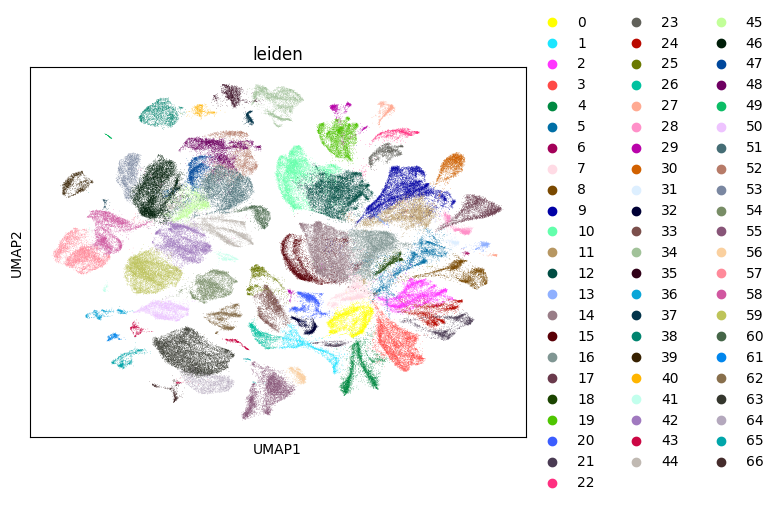

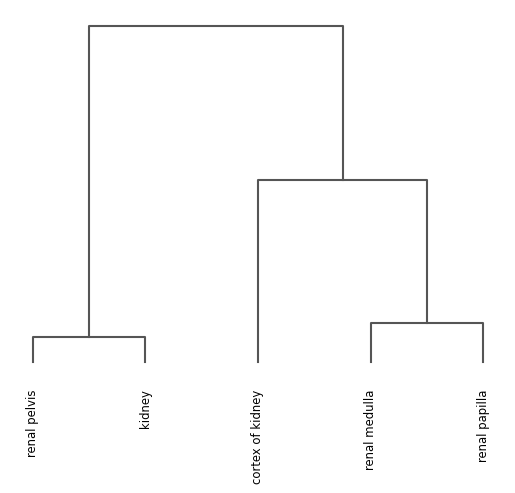

<Axes: >

In [61]:
# Principal Component Analysis (PCA)
sc.pp.pca(normal, svd_solver="arpack")
# Plot the PCA -- Uncomment to see the plot
# sc.pl.pca(normal)
# sc.pl.pca_variance_ratio(normal, log=True)

# Generate UMAP
sc.pp.neighbors(normal)
sc.tl.umap(normal)

# Leiden clustering
sc.tl.leiden(normal, flavor='igraph', n_iterations=2)
sc.pl.umap(normal, color=['leiden']) # Looks better with dark background

# Dendrogram Key for downstream visualization
sc.tl.dendrogram(normal, groupby='cell_type')
sc.tl.dendrogram(normal, groupby='tissue')

## Plotting the Data

#### Expression profile of complement pattern recognition molecules

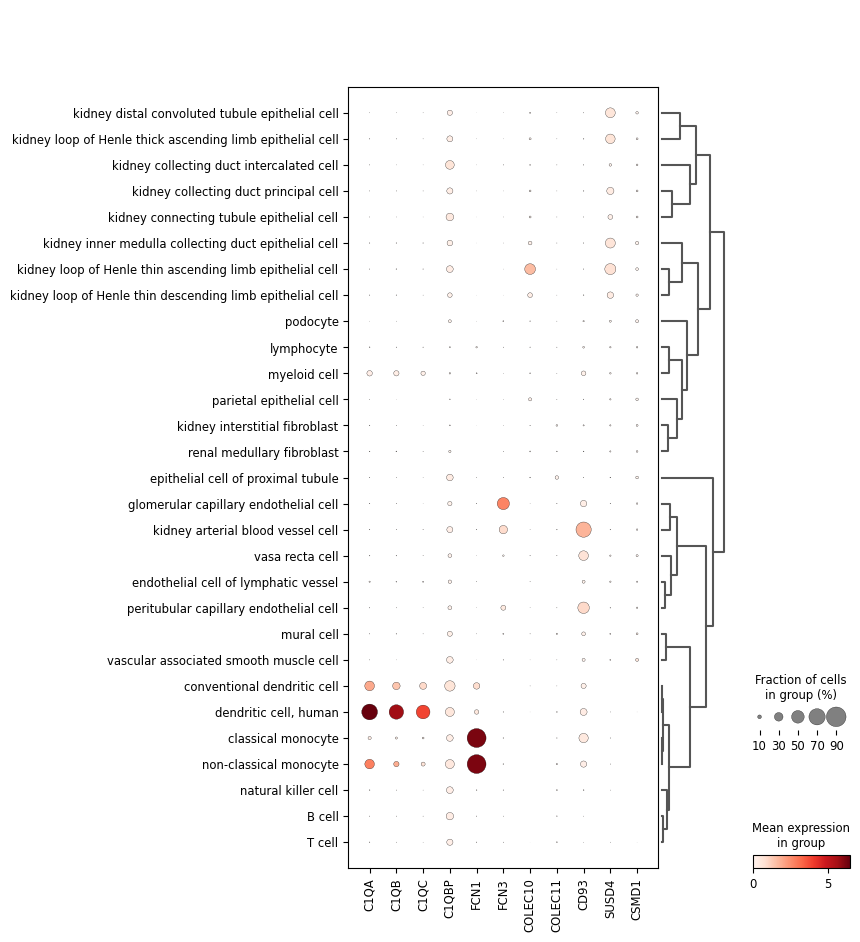

In [80]:
# Define the gene set for plotting
complement_prms = ['C1QA', 'C1QB', 'C1QC', 'C1QBP', 'FCN1', 'FCN3', 'COLEC10', 'COLEC11', 'CD93', 'SUSD4', 'CSMD1']
# Plot the expression of complement PRMs as a dot plot
sc.pl.DotPlot(normal, complement_prms, groupby='cell_type', gene_symbols='feature_name').add_dendrogram(show=True,size=0.9).show()

# Define the gene set for plotting
complement_proteases = ['C1R','MASP1','CFB','C3','C5']
# Plot the expression of complement PRMs as a dot plot
sc.pl.DotPlot(normal, complement_prms, groupby='cell_type', gene_symbols='feature_name').add_dendrogram(show=True,size=0.9).show()

complement_proteases = {
    # 1. Classical Pathway Proteases
    # These enzymes cleave complement components to activate the classical pathway.
    "classical_pathway_proteases": {
        'C1R': 'ENSG00000159403',  # C1r serine protease, cleaves C1s
        'C1S': 'ENSG00000182326'   # C1s serine protease, cleaves C4 and C2
    },

    # 2. Lectin Pathway Proteases
    # These proteases activate the lectin pathway by cleaving complement proteins.
    "lectin_pathway_proteases": {
        'MASP1': 'ENSG00000127241',  # MASP-1, activates MASP-2 and cleaves C2/C4
        'MASP2': 'ENSG00000009724',  # MASP-2, cleaves C4 and C2
        'MASP3': 'XXX'               # MASP-3, alternative function in lectin pathway regulation
    },

    # 3. Alternative Pathway Proteases
    # These enzymes regulate and amplify the alternative pathway.
    "alternative_pathway_proteases": {
        'CFB': 'ENSG00000243649',  # Complement Factor B, cleaved by CFD to form Bb (C3 convertase)
        'CFD': 'ENSG00000197766'   # Complement Factor D, cleaves Factor B to generate Bb
    },

    # 4. Terminal Pathway Proteases
    # These enzymes contribute to C5 cleavage and the formation of the Membrane Attack Complex (MAC).
    "terminal_pathway_proteases": {
        'C5': 'ENSG00000106804'   # Complement component C5, cleaved to form C5a (anaphylatoxin) and C5b (MAC initiator)
    },

    # 5. Regulatory Proteases
    # These enzymes degrade or regulate complement proteins to control excessive activation.
    "regulatory_proteases": {
        'CFI': 'ENSG00000205403',  # Complement Factor I, inactivates C3b and C4b
        'CPB2': 'ENSG00000080618',  # Carboxypeptidase B2 (TAFI), regulates complement activation
        'CPN1': 'ENSG00000120054',  # Carboxypeptidase N subunit 1, modulates complement peptides
        'CPN2': 'ENSG00000178772'   # Carboxypeptidase N subunit 2, stabilizes complement regulation
    }
}

# WORK IN PROGRESS and TESTING